In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing, neighbors, svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
  RandomForestRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, \
    confusion_matrix, classification_report, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV



from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt

import itertools
from itertools import cycle

import pickle
DIR_DATA = "data"
DIR_PROCESSED = "processed"
CV_FOLDS = 5

Data is in creditcard.scv

28 PCA-ed features, Amount of transaction, and class.
Data is unbalanced, 492 frauds/284,807 transations -> 0.172% Fraud rate

In [2]:
df = pd.read_csv(DIR_DATA + '/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
print('Fraud rate: {:.2f}%'.format(np.sum(df.Class) / len(df.Class) * 100))

Fraud rate: 0.17%


In [5]:
# TODO: Data processing? Feature Scaling?

In [7]:
def predict_fraud(df, clf, test_size=0.2):
    X = df.drop(['Class'],1)
    y = df.Class 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    print('Testing Score: {:.3f}'.format(clf.score(X_test, y_test)))
    print('Precision Score: %.3f' % (precision_score(y_test, test_pred)))
    
    print('Recall Score: %.3f' % (recall_score(y_test, test_pred)))
    
    print()

In [9]:
classifiers = [RandomForestClassifier(n_jobs=-1), RandomForestClassifier(criterion='entropy', n_jobs=-1), LogisticRegressionCV(), AdaBoostClassifier(),GradientBoostingClassifier(), neighbors.KNeighborsClassifier(n_jobs=-1)] #, GradientBoostingClassifier(),  neighbors.KNeighborsClassifier(n_jobs=-1)]
# classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1), xgb.XGBClassifier(n_estimators=500, nthread=-1)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    predict_fraud(df, clf)

Classifier  0
Testing Score: 1.000
Precision Score: 0.938
Recall Score: 0.800

Classifier  1
Testing Score: 0.999
Precision Score: 0.943
Recall Score: 0.759

Classifier  2
Testing Score: 0.999
Precision Score: 0.857
Recall Score: 0.526

Classifier  3
Testing Score: 0.999
Precision Score: 0.766
Recall Score: 0.608

Classifier  4
Testing Score: 0.999
Precision Score: 0.865
Recall Score: 0.674

Classifier  5
Testing Score: 0.998
Precision Score: 1.000
Recall Score: 0.031



Random Forest seems best yet again, though K-NN has Perfect Precision

Say something about testing score not really mattering/being perfect for this example

Precision is usually pretty good

In [11]:
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1), xgb.XGBClassifier(n_estimators=500, nthread=-1),  neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=10)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    predict_fraud(df, clf)

Classifier  0
Testing Score: 1.000
Precision Score: 0.958
Recall Score: 0.782

Classifier  1
Testing Score: 1.000
Precision Score: 0.974
Recall Score: 0.798

Classifier  2
Testing Score: 1.000
Precision Score: 0.915
Recall Score: 0.793

Classifier  3
Testing Score: 0.999
Precision Score: 1.000
Recall Score: 0.026



In [ ]:
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1)

I don't think n_estimators is really changing anything

In [12]:
classifiers = [neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=i) for i in range(1,10,2)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    predict_fraud(df, clf)

Classifier  0
Testing Score: 0.998
Precision Score: 0.403
Recall Score: 0.263

Classifier  1
Testing Score: 0.998
Precision Score: 0.909
Recall Score: 0.094

Classifier  2
Testing Score: 0.998
Precision Score: 1.000
Recall Score: 0.041

Classifier  3
Testing Score: 0.998
Precision Score: 1.000
Recall Score: 0.029

Classifier  4
Testing Score: 0.998
Precision Score: 1.000
Recall Score: 0.017



In [23]:
def AUC_PR_Curve(df, clf, test_size=0.2):
    X = df.drop(['Class'],1)
    y = df.Class 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    clf.fit(X_train, y_train)
    
    y_proba = [x[1] for x in clf.predict_proba(X_test)]
    return precision_recall_curve(y_test, y_proba)

In [25]:
clf = RandomForestClassifier(n_jobs=-1)

precision, recall, thresholds = AUC_PR_Curve(df,clf)


In [29]:
curve_list = []
classifiers = [RandomForestClassifier(n_jobs=-1), RandomForestClassifier(criterion='entropy', n_jobs=-1), LogisticRegressionCV(), AdaBoostClassifier(),GradientBoostingClassifier(), neighbors.KNeighborsClassifier(n_jobs=-1)] #, GradientBoostingClassifier(),  neighbors.KNeighborsClassifier(n_jobs=-1)]

for clf in classifiers:
    
    prt = AUC_PR_Curve(df,clf)
    curve_list.append(prt)
print(curve_list)

[(array([ 0.00158   ,  0.27985075,  0.74      ,  0.82758621,  0.875     ,
        0.91780822,  0.94117647,  0.95454545,  0.95081967,  0.96      ,
        0.97142857,  1.        ]), array([ 1.        ,  0.83333333,  0.82222222,  0.8       ,  0.77777778,
        0.74444444,  0.71111111,  0.7       ,  0.64444444,  0.53333333,
        0.37777778,  0.        ]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])), (array([ 0.00168533,  0.2970297 ,  0.82857143,  0.92391304,  0.95294118,
        0.97560976,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ]), array([ 1.        ,  0.9375    ,  0.90625   ,  0.88541667,  0.84375   ,
        0.83333333,  0.77083333,  0.76041667,  0.73958333,  0.61458333,
        0.48958333,  0.        ]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])), (array([ 0.00277711,  0.00275048,  0.00275055, ...,  1.        ,
        1.        ,  1.        ]), array([ 1.        ,  0.990384

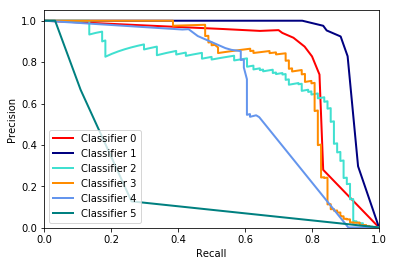

In [33]:
# Plot Precision-Recall curve

plt.clf()
colors = ['red', 'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']

for i, clf in enumerate(classifiers):
    
    precision, recall, thresholds = curve_list[i]
    plt.plot(recall, precision, lw=2, color=colors[i],
         label='Classifier %d' % i)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

In [59]:
def cross_val_left(hr, clf, cv_folds=CV_FOLDS, drop=['left']):
    X = hr.drop(drop, 1)#, 'sales', 'salary'],1)
    y = hr.left 
    scores = cross_val_score(clf, X, y, cv=cv_folds, n_jobs=-1)#, scoring='roc_auc')
    
    
    
    print('Cross val score: ', sum(scores) / cv_folds )
    print(scores)
    
    print()
    

In [62]:
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1)]#, svm.SVC()]#xgb.XGBClassifier(n_estimators=500, nthread=-1)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf)

Classifier  0
Cross val score:  0.991866333178
[ 0.9990003332  0.9806666667  0.9856666667  0.999333111   0.9946648883]

Classifier  1
Cross val score:  0.991666333163
[ 0.998667111   0.9806666667  0.9853333333  0.9989996666  0.9946648883]



In [90]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
X = hr.drop(['left'],1)
y = hr.left 
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, train_sizes=np.linspace(.1, 1.0, 10), cv=5, n_jobs=-1)


In [88]:
print(valid_scores)


[[ 0.9773408864  0.9776666667  0.9816666667  0.9943314438  0.9886628876]
 [ 0.9783405531  0.9783333333  0.9816666667  0.9963321107  0.9913304435]
 [ 0.9783405531  0.979         0.9826666667  0.9973324441  0.9929976659]
 [ 0.9783405531  0.979         0.9813333333  0.9976658886  0.9936645549]
 [ 0.9946684439  0.979         0.9823333333  0.9983327776  0.9939979993]
 [ 0.9993335555  0.9803333333  0.9823333333  0.999333111   0.9943314438]
 [ 0.9990003332  0.9803333333  0.985         0.9989996666  0.9946648883]]


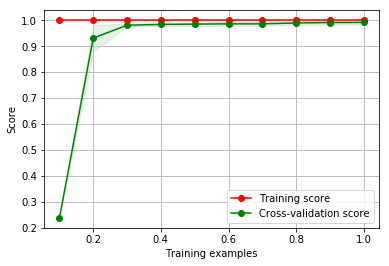

In [96]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
train_sizes = np.linspace(.1,1.0,10)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()
plt.legend(loc="best")
plt.show()

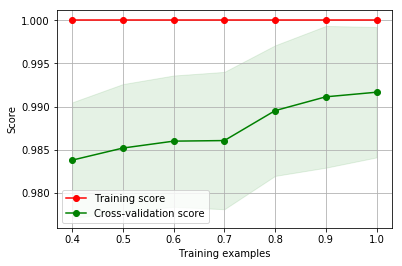

In [94]:
train_scores_mean = np.mean(train_scores, axis=1)[3:] # 0.4 on
train_scores_std = np.std(train_scores, axis=1)[3:]
test_scores_mean = np.mean(valid_scores, axis=1)[3:]
test_scores_std = np.std(valid_scores, axis=1)[3:]
train_sizes = np.linspace(.1,1.0,10)[3:]

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()
plt.legend(loc="best")
plt.show()

In [14]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
X = hr.drop(['left'],1)
y = hr.left 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(X.columns)
clf.feature_importances_
# Drop all lower than 0.01 relevance

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales', 'salary', 'is_4', 'avg_per_team'],
      dtype='object')


array([ 0.32805276,  0.11853322,  0.18245216,  0.14757901,  0.186516  ,
        0.00783057,  0.00129782,  0.00892283,  0.00954625,  0.00080433,
        0.00846506])

In [39]:
# Dropping all with <0.01 relevance seems to not affect score much (.9920->.9916)
drop = ['left', 'promotion_last_5years', 'Work_accident', 'sales', 'salary']
for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

Classifier  0
Cross val score:  0.99450795097
[ 0.99989599  0.98623671  0.98705094  0.99963132  0.99972479]

Classifier  1
Cross val score:  0.994485333896
[ 0.99990578  0.98579436  0.98744887  0.99962519  0.99965246]



In [16]:
hr.corr()["left"]

satisfaction_level      -0.388375
last_evaluation          0.006567
number_project           0.023787
average_montly_hours     0.071287
time_spend_company       0.144822
Work_accident           -0.154622
left                     1.000000
promotion_last_5years   -0.061788
sales                    0.032105
salary                  -0.001294
is_4                    -0.046035
Name: left, dtype: float64

In [40]:
# Drop everything with corr to left of < 0.005
# Makes it worse
drop = ['left',  'sales', 'salary']
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1)]#, svm.SVC()]#xgb.XGBClassifier(n_estimators=500, nthread=-1)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

Classifier  0
Cross val score:  0.994111289948
[ 0.99968583  0.98524786  0.98646125  0.99962488  0.99953662]

Classifier  1
Cross val score:  0.994280805443
[ 0.99987427  0.98537989  0.98719829  0.99943763  0.99951394]



In [18]:
from sklearn.feature_selection import RFE
model = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf = RFE(model,7 )

X = hr.drop(['left'],1)
y = hr.left 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(clf.support_)
print(clf.ranking_)
# Gets same result as feature_importance, which makes sense

[ True  True  True  True  True False False  True  True False False]
[1 1 1 1 1 3 4 1 1 5 2]


In [19]:
# from sklearn.feature_selection import RFE
# model = svm.SVC(kernel='linear')
# clf = RFE(model,5 )

# X = hr.drop(['left'],1)
# y = hr.left 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
# clf.fit(X_train, y_train)
# print(clf.support_)
# print(clf.ranking_)
# # Gets same result as feature_importance

In [20]:
# PCA on relevant features
drop = ['left',  'sales', 'salary']

y = np.array(hr.left)

X = np.array(hr.drop(drop,1))
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

In [21]:
print(pca.components_)

[[ -1.00023272e-04   1.16454622e-03   1.03016962e-02   9.99939260e-01
    3.73903656e-03  -7.14279268e-05  -1.02210886e-05   3.40923099e-06
   -1.97930557e-06]
 [ -2.15441037e-02   1.53800123e-02   2.72326123e-01  -6.42153324e-03
    9.61671473e-01   7.51616199e-04   6.30737234e-03   1.55475088e-02
    1.56786116e-03]]


In [22]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[  9.98549061e-01   8.69441180e-04]
0.999418502162


In [23]:
# Still get good accuracy, ~97%
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
y = np.array(hr.left) 

scores = cross_val_score(clf, X_pca, y, cv=CV_FOLDS, n_jobs=-1)
    
    
    
print('Cross val score: ', sum(scores) / CV_FOLDS )
print(scores)

Cross val score:  0.971332998837
[ 0.97634122  0.953       0.956       0.98466155  0.98666222]


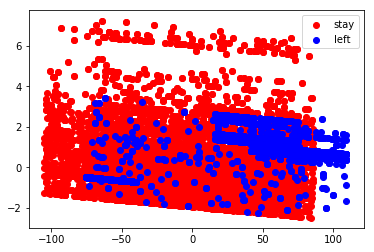

In [24]:
colors = cycle('rb')
target_ids = range(2)
plt.figure()
for i, c, label in zip(target_ids, colors, ["stay","left"]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
                c=c, label=label)
plt.legend()
plt.show()

/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


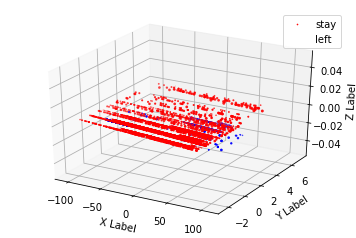

In [25]:
# 3D PCA, Clear plane difference between them
drop = ['left',  'sales', 'salary']

y = np.array(hr.left)

X = np.array(hr.drop(drop,1))
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

colors = cycle('rb')
target_ids = range(2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, c, label in zip(target_ids, colors, ["stay","left"]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],X_pca[y == i, 2],
                c=c, label=label)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
    
plt.legend()
plt.show()

In [26]:
# 3D accuracy is the same as 2D
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
y = hr.left 

scores = cross_val_score(clf, X_pca, y, cv=CV_FOLDS, n_jobs=-1)
    
    
    
print('Cross val score: ', sum(scores) / CV_FOLDS )
print(scores)

Cross val score:  0.970999798837
[ 0.97534155  0.95033333  0.957       0.98366122  0.98866289]


In [27]:
# Attempt to find department level features, doesn't seem to matter
hr_corr = hr.corr()
hr_corr["sales"]

satisfaction_level       0.003153
last_evaluation          0.007772
number_project           0.009268
average_montly_hours     0.003913
time_spend_company      -0.018010
Work_accident            0.003425
left                     0.032105
promotion_last_5years   -0.027336
sales                    1.000000
salary                   0.000685
is_4                    -0.136533
Name: sales, dtype: float64

In [28]:
hr.columns.values

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'left', 'promotion_last_5years', 'sales', 'salary', 'is_4',
       'avg_per_team'], dtype=object)

In [29]:
for col in hr.columns:
    depProperties = hr.groupby('sales').agg({col:[np.size,np.mean]})
    print(depProperties)

      satisfaction_level          
                    size      mean
sales                             
0                 1227.0  0.618142
1                  787.0  0.619822
2                  767.0  0.582151
3                  739.0  0.598809
4                  630.0  0.621349
5                  858.0  0.618601
6                  902.0  0.619634
7                 4140.0  0.614447
8                 2229.0  0.618300
9                 2720.0  0.607897
      last_evaluation          
                 size      mean
sales                          
0              1227.0  0.716830
1               787.0  0.712122
2               767.0  0.717718
3               739.0  0.708850
4               630.0  0.724000
5               858.0  0.715886
6               902.0  0.714756
7              4140.0  0.709717
8              2229.0  0.723109
9              2720.0  0.721099
      number_project          
                size      mean
sales                         
0               1227  3.816626
1    

DataError: No numeric types to aggregate

In [44]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
X = hr.drop(drop,1)
y = hr.left 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

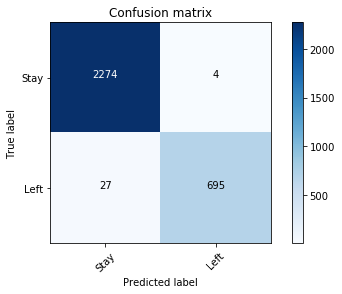

In [51]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=10)

class_names = ["Stay","Left"]

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()

In [55]:
print(classification_report(y_test,y_pred, target_names=class_names))

             precision    recall  f1-score   support

       Stay       0.99      1.00      0.99      2278
       Left       0.99      0.96      0.98       722

avg / total       0.99      0.99      0.99      3000

